In [12]:
import ants
import numpy as np
from scipy.ndimage import center_of_mass, binary_fill_holes
from scipy.spatial.distance import euclidean

from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os

In [13]:
dir_processed = Path("/media/maichi/T7/AIDREAM_DATA/processed")

In [16]:
list_patients = os.listdir(dir_processed)
list_patients = list(set(list_patients) - {"AIDREAM_50", "AIDREAM_152", 'AIDREAM_102'})

list_patients = [list_patients[i] for i in np.argsort([int(p.strip('AIDREAM_')) for p in list_patients])]

In [19]:
df_vol = pd.DataFrame(columns=["id_aidream", "vol L3 pre_RT", "vol L3 Rechute"])

for patient in tqdm(list_patients):

    path_prert_L3 = dir_processed / patient / "pre_RT" / "Labels" / fr"{patient}_pre_RT_L3_Label.nii.gz"
    prert_L3 = ants.image_read(str(path_prert_L3)).numpy()
    prert_vol = prert_L3.sum()

    path_rechute_L3 = dir_processed / patient / "Rechute" / "Labels" / fr"{patient}_Rechute_L3_Label.nii.gz"
    rechute_L3 = ants.image_read(str(path_rechute_L3)).numpy()
    rechute_vol = rechute_L3.sum()


    df_vol.loc[len(df_vol)] = {"id_aidream": patient, "vol L3 pre_RT": prert_vol, "vol L3 Rechute": rechute_vol}
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 14.59it/s]


In [21]:
df_vol.to_csv("volumes.csv", index=False)

In [22]:
def ensure_compact_mask(mask):
    return binary_fill_holes(mask).astype(int)

In [23]:
def calculate_centroid(mask):
    return center_of_mass(mask)

In [30]:
def relapse_distance(original_mask, relapse_mask):

    original_mask = ensure_compact_mask(original_mask)
    relapse_mask = ensure_compact_mask(relapse_mask)

    original_centroid = calculate_centroid(original_mask)
    relapse_centroid = calculate_centroid(relapse_mask)

    distance = euclidean(original_centroid, relapse_centroid)

    return distance, original_centroid, relapse_centroid

In [29]:
def get_mask(patient, stage):

    imgs = [
        ants.image_read(str(dir_processed / patient / stage / "Labels" / fr"{patient}_{stage}_L{i}_Label.nii.gz")).numpy() for i in range(1, 4)
    ]

    return np.sum(imgs, axis=0)

In [32]:
def dice_coefficient(mask1, mask2):

    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    volume1 = np.sum(mask1 > 0)
    volume2 = np.sum(mask2 > 0)
    
    if volume1 + volume2 == 0:
        return 1.0  # Both masks are empty
    
    dice = 2.0 * intersection / (volume1 + volume2)
    return dice

In [34]:
df_dist = pd.DataFrame(columns=['id_aidream', 'distance', 'dice', 'original_centroid','relapse_centroid'])

for patient in tqdm(list_patients):

    try:

        original_mask = get_mask(patient, 'pre_RT')
        relapse_mask = get_mask(patient, 'Rechute')
    
        distance, original_centroid, relapse_centroid = relapse_distance(original_mask, relapse_mask)
        dice = dice_coefficient(original_mask, relapse_mask)
    
        df_dist.loc[len(df_dist)] = {"id_aidream": patient, "distance": distance, 'dice': dice, "original_centroid": original_centroid, "relapse_centroid": relapse_centroid}

    except Exception as e:
        print(fr"failed for patient {patient} , error = {e}")

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 77/104 [01:03<00:22,  1.22it/s]/home/maichi/anaconda3/envs/env_relapse_prediction/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1542: RuntimeWarning:

invalid value encountered in scalar divide

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 78/104 [01:04<00:21,  1.21it/s]

failed for patient AIDREAM_130 , error = array must not contain infs or NaNs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [01:25<00:00,  1.21it/s]


In [41]:
df_dist = df_dist.sort_values(by="distance").reset_index(drop=True)

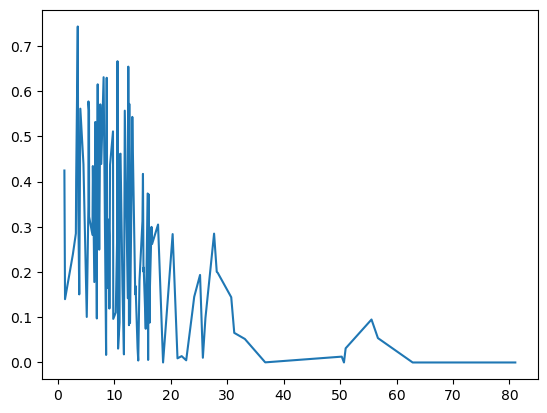

In [42]:
import matplotlib.pyplot as plt
plt.plot(df_dist["distance"], df_dist["dice"])

In [46]:
df = df_vol.merge(df_dist, on="id_aidream",how="left")

In [47]:
df

,id_aidream,vol L3 pre_RT,vol L3 Rechute,distance,dice,original_centroid,relapse_centroid
0,AIDREAM_1,0.0,17159.0,21.227439,0.009204,"(149.21288837744535, 111.77100115074799, 58.32...","(148.1139209031119, 123.23873285840389, 76.151..."
1,AIDREAM_2,0.0,2038.0,9.292140,0.437339,"(167.10068200208067, 144.7004970523639, 52.147...","(162.38368292018524, 136.779941886861, 53.3133..."
2,AIDREAM_3,10074.0,13470.0,5.463410,0.577378,"(71.69597349643222, 140.76822120285422, 96.359...","(69.26600833204752, 136.72046494882477, 93.610..."
3,AIDREAM_4,0.0,1632.0,10.972386,0.088827,"(103.18772745972974, 75.81999430361721, 96.860...","(100.55359628770302, 68.53364269141531, 104.63..."
4,AIDREAM_6,0.0,31071.0,11.744453,0.017923,"(82.18176855895196, 151.01200873362444, 72.201...","(86.83007320166506, 143.94845360824743, 80.352..."
...,...,...,...,...,...,...,...
99,AIDREAM_242,35656.0,47597.0,5.568539,0.558188,"(88.88033483580168, 118.576132217214, 79.47514...","(91.32757126856998, 120.06027626916872, 84.251..."
100,AIDREAM_243,17652.0,9984.0,31.276553,0.065507,"(158.3304190716399, 136.19751903768736, 61.845...","(160.83249949969982, 105.33890334200521, 57.40..."
101,AIDREAM_244,52427.0,38986.0,9.809380,0.511105,"(152.87608570364816, 159.62297841088179, 61.76...","(150.0059832052992, 152.2021995544263, 67.4976..."
102,AIDREAM_245,8456.0,11072.0,5.457025,0.346348,"(87.51191664337898, 126.9661663140245, 103.271...","(86.80649526387009, 131.27081641858368, 106.55..."


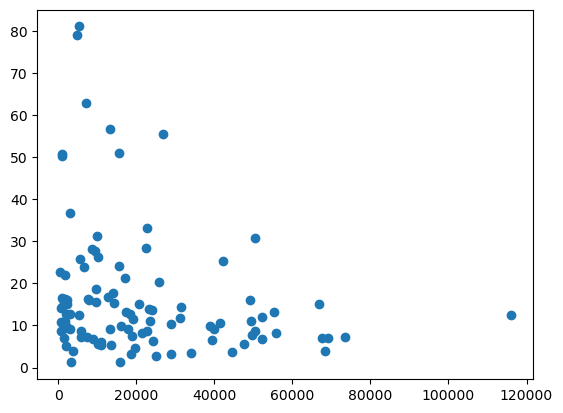

In [49]:
plt.scatter(df["vol L3 Rechute"], df['distance'])

In [50]:
def plot_columns(df, columns=None):
    """
    Plot columns of a DataFrame against each other.

    Parameters:
    - df: pd.DataFrame, the DataFrame containing the data
    - columns: list of str, list of column names to plot. If None, all columns are used.

    Returns:
    - None
    """
    if columns is None:
        columns = df.columns

    num_columns = len(columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=num_columns, figsize=(15, 15))

    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i != j:
                axes[i, j].scatter(df[col1], df[col2])
                axes[i, j].set_xlabel(col1)
                axes[i, j].set_ylabel(col2)
            else:
                axes[i, j].text(0.5, 0.5, col1, horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()

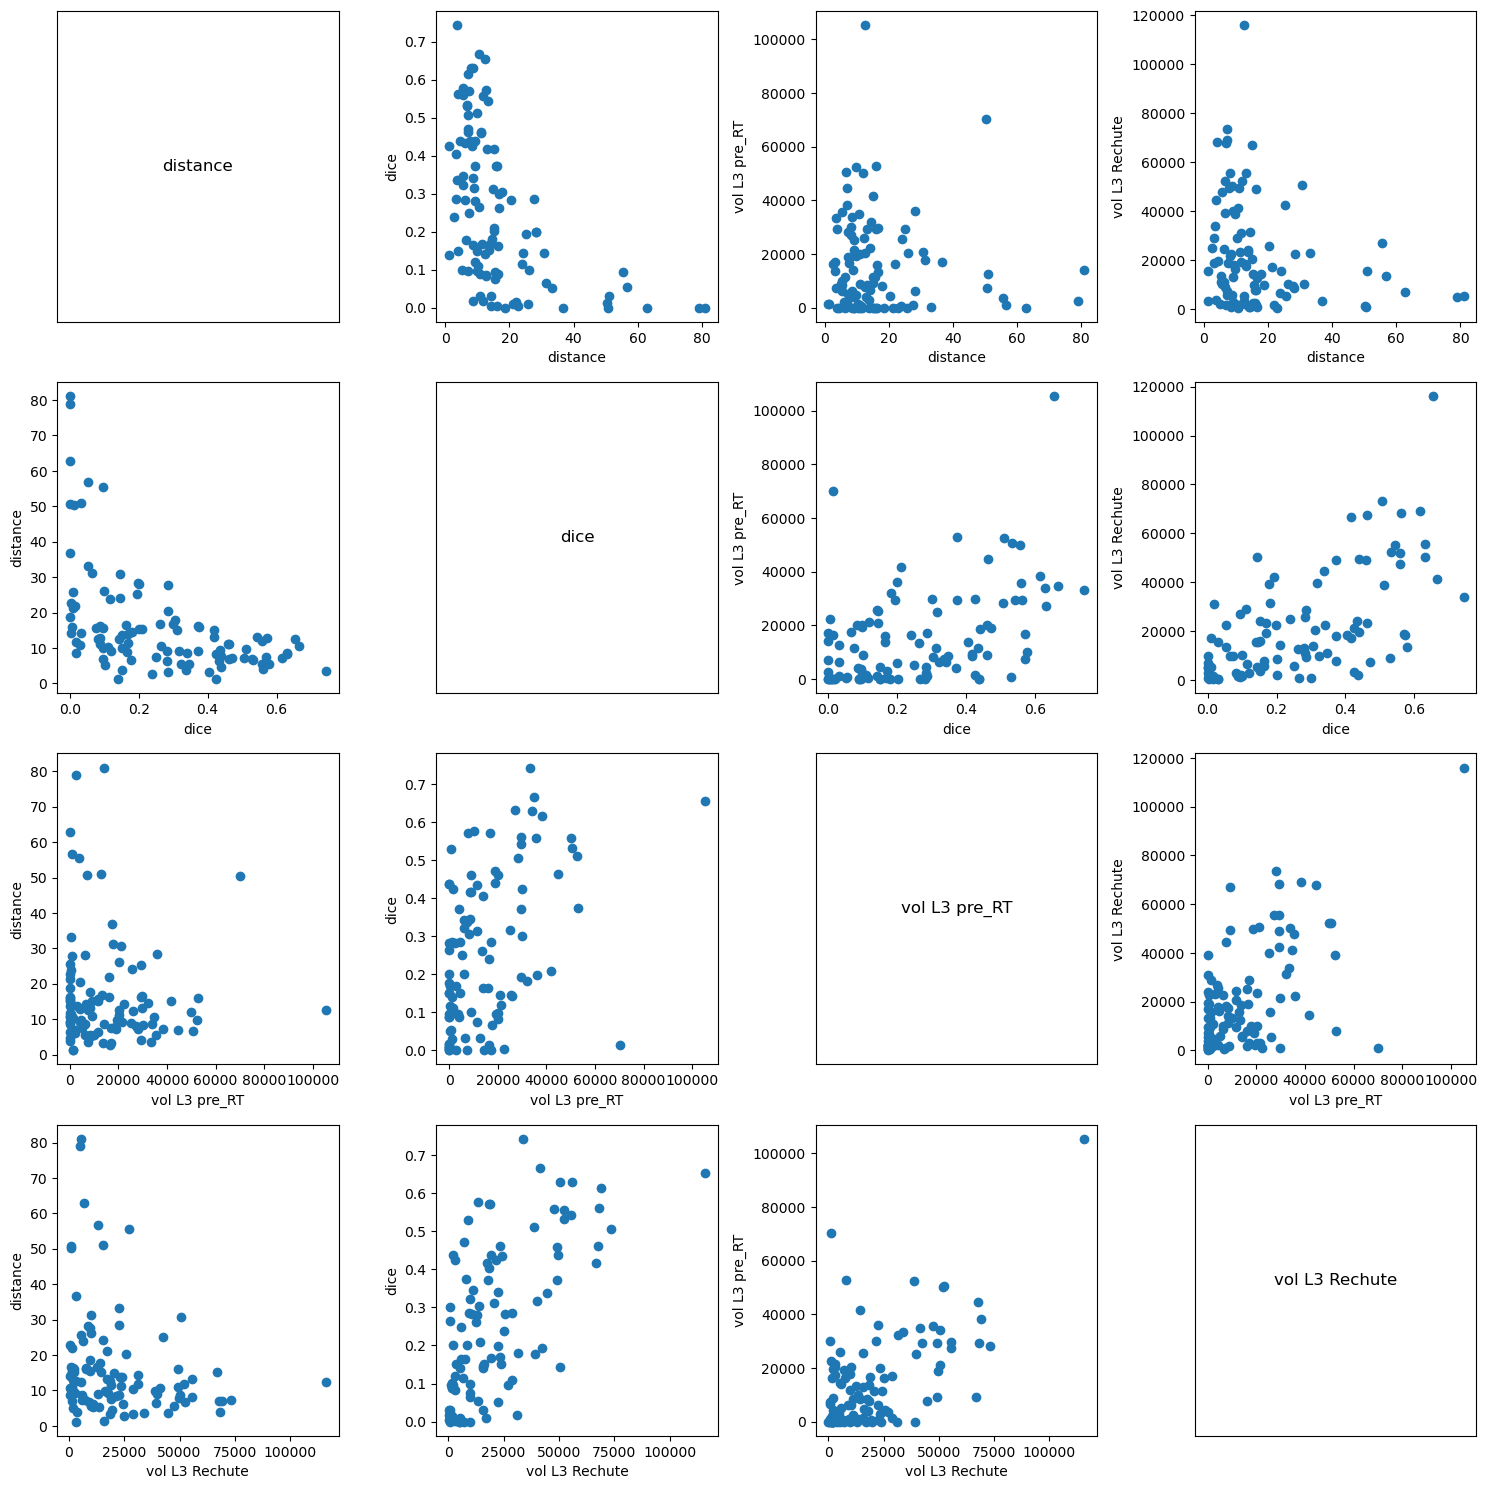

In [51]:
plot_columns(df, columns=['distance','dice', 'vol L3 pre_RT', 'vol L3 Rechute'])